# Rt Live Model

Based on [Rt.live](https://Rt.live) model, original source code on [Github](https://github.com/rtcovidlive/covid-model).

Adapted for South Africa - Schalk van Heerden - 3 Aug 2020

In [1]:
%load_ext autoreload
%autoreload 2

from pip._internal import main
try:
    import pymc3 as pm
except:
    from pip._internal import main
    main(['install', 'pymc3'])
    import pymc3 as pm
        
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

## Setup
TODO: Complete GitHub automation. Progress: can install all libaries with conda, but issue running this complex notebook remotely in a GitHub Action. Move to a flat python file next.

Change paramter to **False** when running on your own local machine, but do not commit this change! Leave as **True** for Github Action `rtlive_model_action.yaml` to run remotely.

In [2]:
us_run = False

In [3]:
remote_run = False

## Troubleshooting

1. Ensure that all modules are installed with `conda` from `requirements.txt`
1. How to solve Theano library warnings on some OS platforms: [SO](https://stackoverflow.com/questions/53423610/how-to-update-scan-cython-code-in-theano)

# Baseline model with US data

While testing, run US model first to baseline the latest model files. Remote run is not required. For the latest stable model, checkout commit from 2 July 2020.

## Fetch data and select the state's data

In [4]:
if us_run:
    df = get_and_process_covidtracking_data(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [5]:
if us_run:
    region = "OR"
    model_data = df.loc[region]
    model_data.tail()

## Create the model instance and sample

In [6]:
if us_run:
    gm = GenerativeModel(region, model_data)
    gm.sample()

## Summarize Model Output

In [7]:
result = pd.DataFrame()
if us_run:
    result = summarize_inference_data(gm.inference_data)
result.tail(10)

""


## Plot Model Output

In [8]:
def plot_results():
    fig, ax = plt.subplots(figsize=(10,5))
    result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
    result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
    result.infections.plot(c="b", label="Infections")
    gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
    fig.set_facecolor('w')
    ax.legend();
 
if us_run:
    plot_results()

In [9]:
def plot_rt():
    fig, ax = plt.subplots(figsize=(10,5))

    ax.set_title(f"{region} $R_t$")
    samples = gm.trace['r_t']
    x=result.index
    cmap = plt.get_cmap("Reds")
    percs = np.linspace(51, 99, 40)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    samples = samples.T

    result["median"].plot(c="k", ls='-')

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(samples, p, axis=1)
        lower = np.percentile(samples, 100-p, axis=1)
        color_val = colors[i]
        ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

    ax.axhline(1.0, c="k", lw=1, linestyle="--")
    fig.set_facecolor('w')
 
if us_run:
    plot_rt()

# South African Results

## Download data

In [10]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_cases.tail()

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-08-02,20200802,79410.0,23099.0,180532.0,82300.0,9044.0,15120.0,5131.0,19961.0,96838.0,50.0,511485,https://twitter.com/nicd_sa/status/12900128140...
2020-08-03,20200803,79674.0,23705.0,181946.0,84361.0,9204.0,15395.0,5302.0,20149.0,97076.0,50.0,516862,https://twitter.com/COVID_19_ZA/status/1290375...
2020-08-04,20200804,79844.0,24333.0,183090.0,85986.0,9389.0,15716.0,5379.0,20270.0,97261.0,50.0,521318,https://twitter.com/DrZweliMkhize/status/12907...
2020-08-05,20200805,80400.0,25232.0,185282.0,87798.0,9625.0,17135.0,5638.0,20686.0,98031.0,50.0,529877,https://twitter.com/nicd_sa/status/12911072678...
2020-08-06,20200806,81014.0,26123.0,187631.0,90115.0,9873.0,17803.0,5932.0,21044.0,98599.0,50.0,538184,https://twitter.com/nicd_sa/status/12914823911...


In [11]:
#url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_testing.csv'
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests.tail()

,YYYYMMDD,cumulative_tests,recovered,hospitalisation,critical_icu,ventilation,deaths,contacts_identified,contacts_traced,scanned_travellers,passengers_elevated_temperature,covid_suspected_criteria,source
date,,,,,,,,,,,,,
2020-08-02,20200803,3036779.0,347227,NaN,NaN,NaN,8366,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/08/02/update-...
2020-08-03,20200803,3058695.0,358037,NaN,NaN,NaN,8539,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/08/03/update-...
2020-08-04,20200804,3078202.0,363751,NaN,NaN,NaN,8884,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/08/04/update-...
2020-08-05,20200805,3113191.0,377266,NaN,NaN,NaN,9298,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/08/05/update-...
2020-08-06,20200806,3149807.0,387316,NaN,NaN,NaN,9604,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/08/06/update-...


## Cleanup data

In [12]:
cases = pd.Series(states_cases['total'], index=states_cases.index, name='cases')
cases

date
2020-03-05         1
2020-03-07         2
2020-03-08         3
2020-03-09         7
2020-03-11        13
               ...  
2020-08-02    511485
2020-08-03    516862
2020-08-04    521318
2020-08-05    529877
2020-08-06    538184
Name: cases, Length: 153, dtype: int64

In [13]:
casezero = states_cases.index[0]
caselast = states_cases.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-08-06 00:00:00'))

In [14]:
idx = pd.date_range(casezero, caselast)

In [15]:
tests_all = pd.Series(states_tests['cumulative_tests'], index=states_tests.index, name='tests')
tests_all

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-08-02    3036779.0
2020-08-03    3058695.0
2020-08-04    3078202.0
2020-08-05    3113191.0
2020-08-06    3149807.0
Name: tests, Length: 160, dtype: float64

In [16]:
tests = tests_all.loc[casezero:caselast]
tests

date
2020-03-06        200.0
2020-03-07        241.0
2020-03-11        645.0
2020-03-12        848.0
2020-03-13        924.0
                ...    
2020-08-02    3036779.0
2020-08-03    3058695.0
2020-08-04    3078202.0
2020-08-05    3113191.0
2020-08-06    3149807.0
Name: tests, Length: 151, dtype: float64

In [17]:
combined_model = pd.concat([cases, tests], axis=1)
combined_model

,cases,tests
date,,
2020-03-05,1.0,NaN
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-08-02,511485.0,3036779.0
2020-08-03,516862.0,3058695.0
2020-08-04,521318.0,3078202.0


In [18]:
# Assume previous day testing result for missing data point
combined_model.loc[casezero,'tests'] = 163

In [19]:
# Reindex complete date range
filled_model = combined_model.reindex(idx, method='ffill')
filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-08-02,511485.0,3036779.0
2020-08-03,516862.0,3058695.0
2020-08-04,521318.0,3078202.0
2020-08-05,529877.0,3113191.0


In [20]:
# Do a final clean up, assume previous day results for missing data points
final_filled_model = filled_model.ffill(axis=0)
final_filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,1.0,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,241.0
2020-03-09,7.0,241.0
...,...,...
2020-08-02,511485.0,3036779.0
2020-08-03,516862.0,3058695.0
2020-08-04,521318.0,3078202.0
2020-08-05,529877.0,3113191.0


In [21]:
# Add delta columns for models
final_filled_model['positive'] = final_filled_model['cases'].diff()
final_filled_model['total'] = final_filled_model['tests'].diff()
final_filled_model

,cases,tests,positive,total
2020-03-05,1.0,163.0,NaN,NaN
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
...,...,...,...,...
2020-08-02,511485.0,3036779.0,8195.0,34794.0
2020-08-03,516862.0,3058695.0,5377.0,21916.0
2020-08-04,521318.0,3078202.0,4456.0,19507.0
2020-08-05,529877.0,3113191.0,8559.0,34989.0


In [22]:
df_model = final_filled_model.iloc[1:]
df_model

,cases,tests,positive,total
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
2020-03-10,7.0,241.0,0.0,0.0
...,...,...,...,...
2020-08-02,511485.0,3036779.0,8195.0,34794.0
2020-08-03,516862.0,3058695.0,5377.0,21916.0
2020-08-04,521318.0,3078202.0,4456.0,19507.0
2020-08-05,529877.0,3113191.0,8559.0,34989.0


## Calculate Rt

In [23]:
region = 'Total RSA'

In [24]:
gm = GenerativeModel(region, df_model)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
Sampling 4 chains, 0 divergences: 100%|██████████| 3600/3600 [14:09<00:00,  4.24draws/s]


## Show results

In [25]:
result = summarize_inference_data(gm.inference_data)

100%|██████████| 800/800 [00:02<00:00, 367.25it/s]


In [26]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-07-28,0.945565,0.937971,0.787667,1.081319,6910.004099,9010.544921,8761.265702,7232.0,28424.0
2020-07-29,0.946873,0.939709,0.786985,1.090140,6849.059539,8949.747938,9199.695524,11362.0,42528.0
2020-07-30,0.948733,0.938599,0.773265,1.095909,6792.809383,8885.388180,8473.986389,11046.0,44886.0
2020-07-31,0.950138,0.940049,0.786231,1.119271,6741.609584,8818.201859,9141.914126,11014.0,41486.0
2020-08-01,0.948228,0.940721,0.774746,1.110766,6696.558196,8748.923229,8198.571707,10107.0,42450.0
2020-08-02,0.949185,0.940535,0.741750,1.091430,6657.989610,8678.165611,8110.324427,8195.0,34794.0
2020-08-03,0.949101,0.932062,0.766235,1.127100,6623.581381,8606.420204,8448.359249,5377.0,21916.0
2020-08-04,0.949707,0.931651,0.769748,1.137056,6592.893473,8534.259539,7865.898291,4456.0,19507.0
2020-08-05,0.950819,0.935070,0.747028,1.123980,6567.396871,8462.379315,8423.355389,8559.0,34989.0


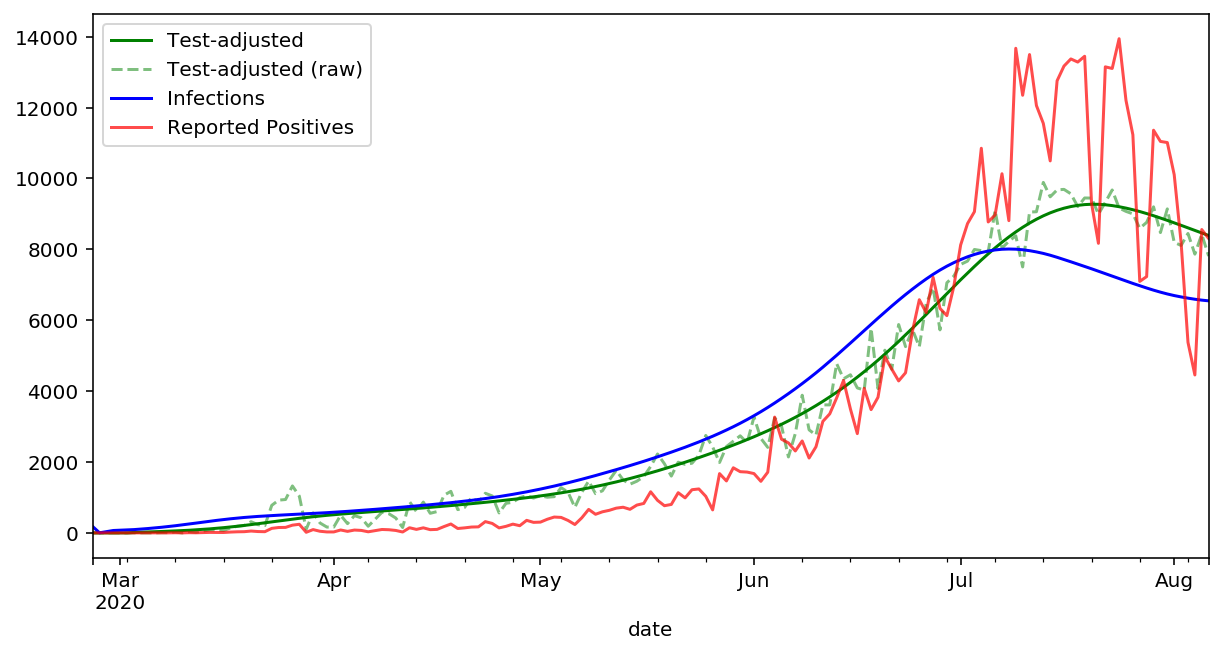

In [27]:
plot_results()

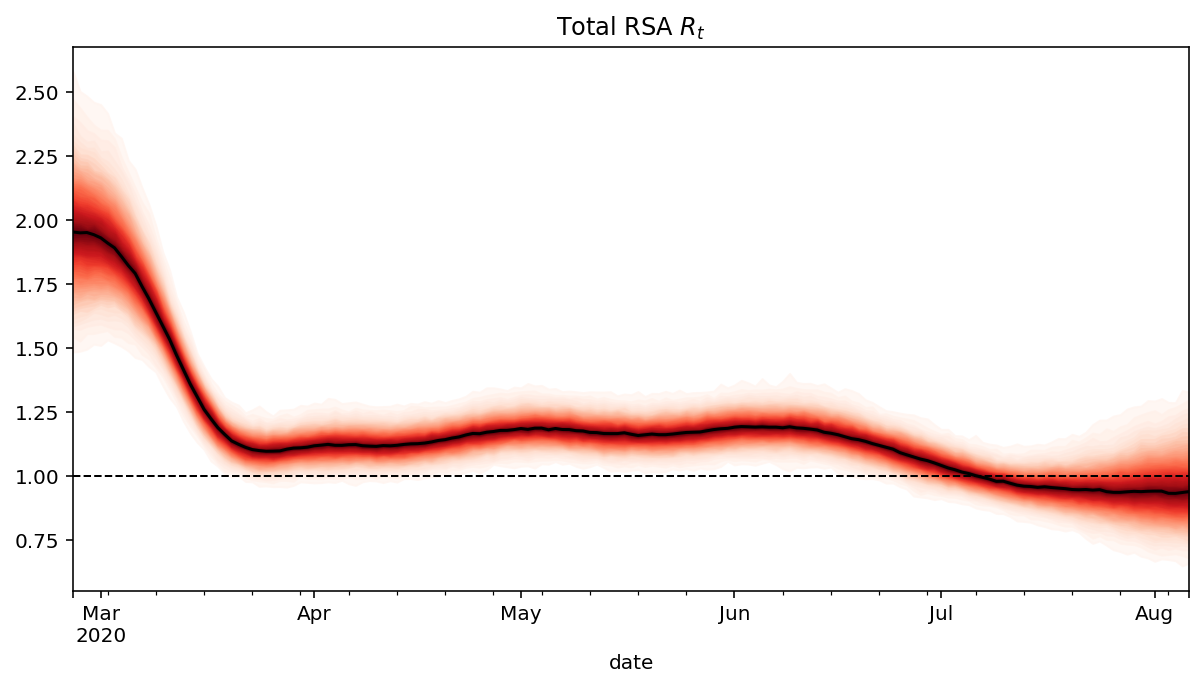

In [28]:
plot_rt()

In [29]:
export_results = result[['median','upper_80','lower_80','infections','test_adjusted_positive']]
export_results = export_results.rename(columns={'median':'Median','upper_80':'High_80','lower_80':'Low_80','infections':'Infections','test_adjusted_positive':'Adjusted_Postive'})
export_results.tail()

,Median,High_80,Low_80,Infections,Adjusted_Postive
date,,,,,
2020-08-02,0.940535,1.091430,0.741750,6657.989610,8678.165611
2020-08-03,0.932062,1.127100,0.766235,6623.581381,8606.420204
2020-08-04,0.931651,1.137056,0.769748,6592.893473,8534.259539
2020-08-05,0.935070,1.123980,0.747028,6567.396871,8462.379315
2020-08-06,0.938682,1.124554,0.737072,6547.847918,8391.538089


## Export results

In [30]:
if remote_run:
    # Used by GitHub Action, TODO complete the action!
    # The path needs to be linked directly, TODO find out why relative path does not work
    # Action instance path /home/runner/work/covid19za/covid19za
    export_results.to_csv('data/calc/calculated_rt_sa_mcmc.csv', float_format='%.3f')

else:
    export_results.to_csv('../../data/calc/calculated_rt_sa_mcmc.csv', float_format='%.3f')